In [1]:
## General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import random
import time
import select
import sys

# Pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Image processing imports
import cv2
from PIL import Image

In [2]:
from model import CLASS_LABEL_DICT, IMG_SIZE, CNN1
from image_processing import contrast_enhancement, find_object_contours
from card_processing import get_icons, display_card

CLIP_LIMIT = 4.0
BINARY_THRESHOLD = 200
SYM_CARD_SIZE_RATIO = 1/20

In [3]:
def model_move(model_card, shared_icons, shared_contours):
    model_icons, model_contours = get_icons(model_card, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
    model_matches = [item for item in model_icons if item in shared_icons]
    if model_matches:
        model_match = model_matches[0]
    else:
        return None
    model_contour = model_contours[model_icons.index(model_match)]
    shared_contour = shared_contours[shared_icons.index(model_match)]
    return model_match, model_contour, shared_contour

def get_user_move(match):
    user_input = input("Enter the match: ")
    if user_input == match:
        return True
    else: 
        return False

# def get_user_move(expected_match, timeout=0.1):
#     user_input = input("Make your move (enter symbol): ")
#     rlist, _, _ = select.select([sys.stdin], [], [], timeout)
#     if rlist:
#         user_input = sys.stdin.readline().strip()
#         return user_input == expected_match  # Compare input to the expected match
#     return None  # Return None if no input is received


In [4]:
# Define & Load Model
model_path = "model_v4.pth"
model = CNN1(num_classes=len(CLASS_LABEL_DICT))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=57, bias=True)
  (small_dropout): Dropout(p=0.1, inplace=False)
  (large_dropout): Dropout(p=0.3, inplace=False)
)

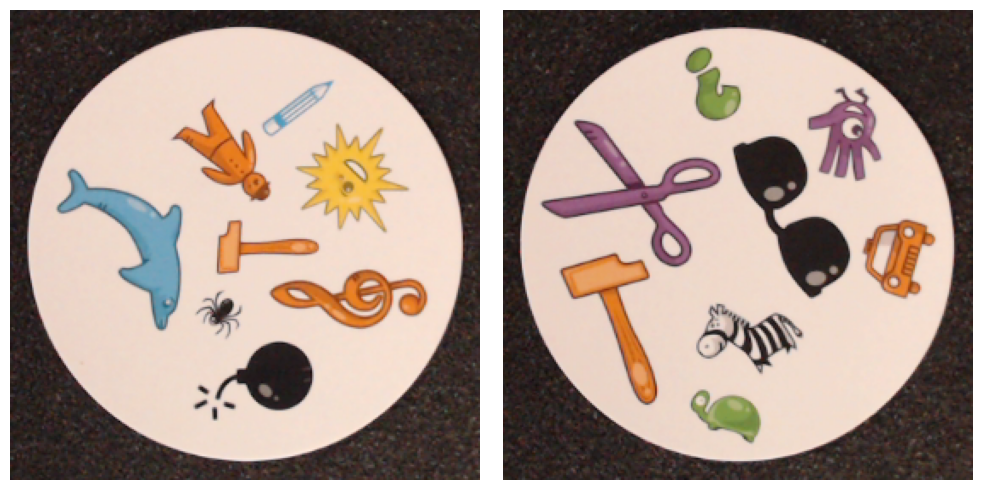

Correct!


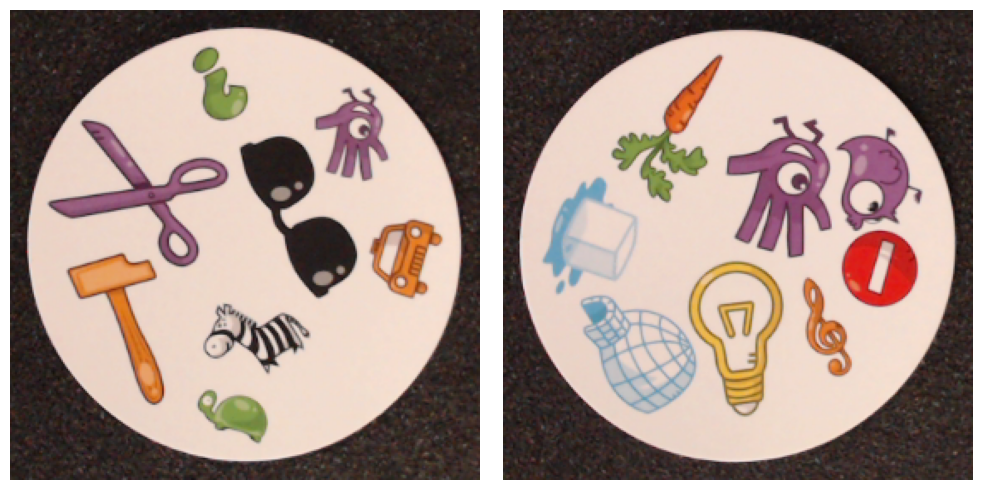

Correct!
Issue finding contours
Get new shared card


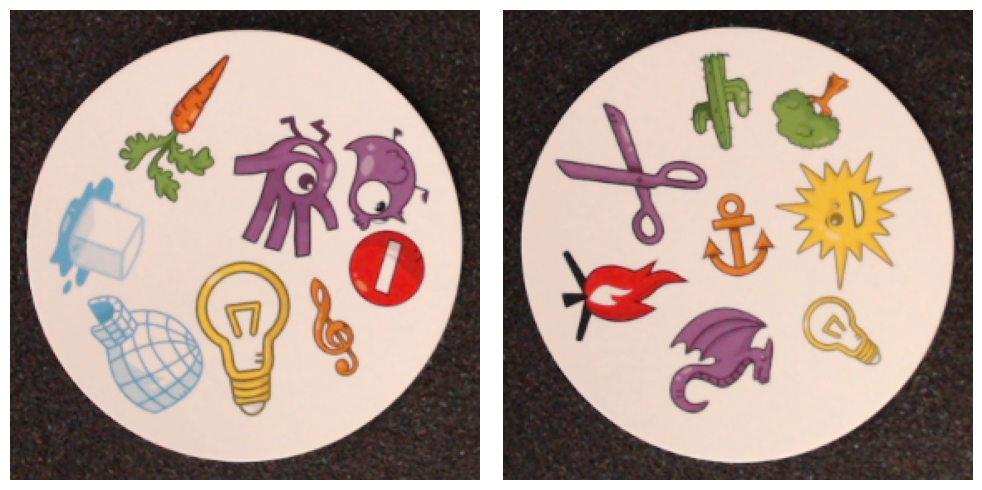

Correct!
Issue finding contours
Get new shared card


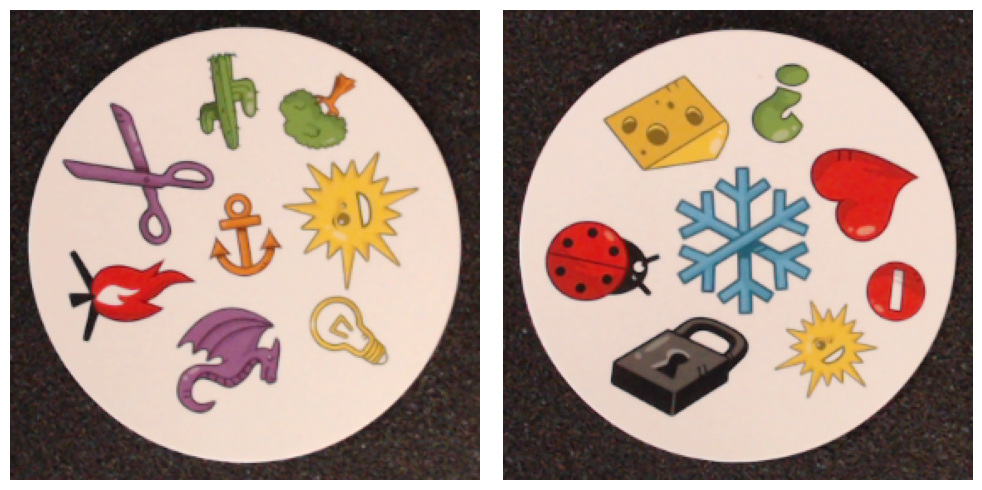

Model Wins!
Model Matching


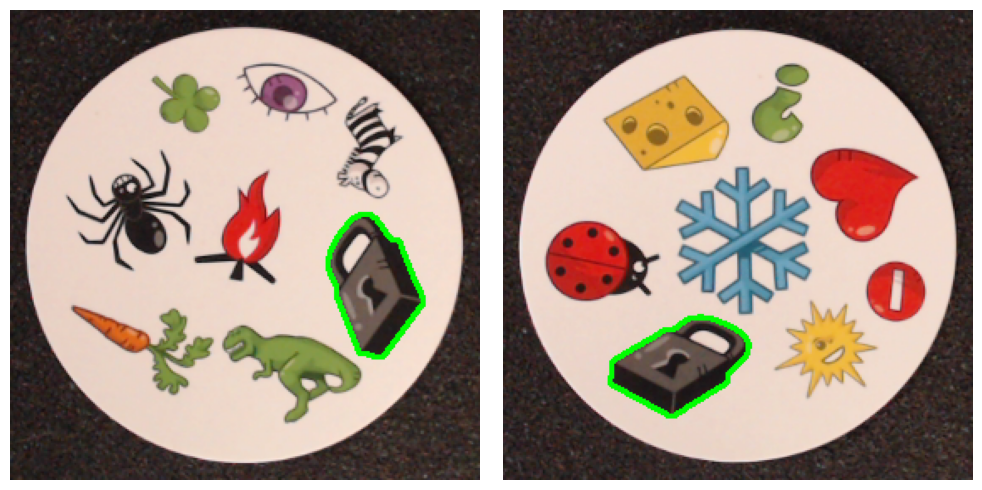

Supposed User Matching


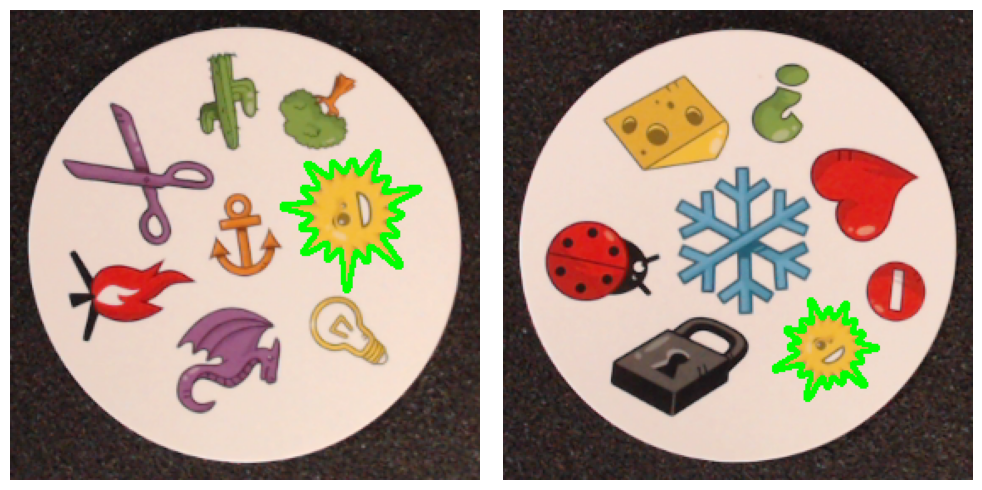

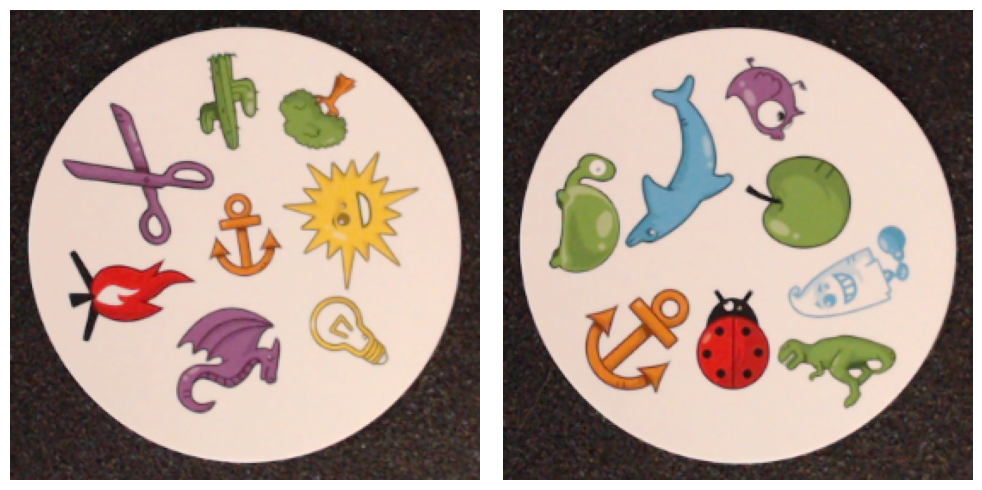

Correct!


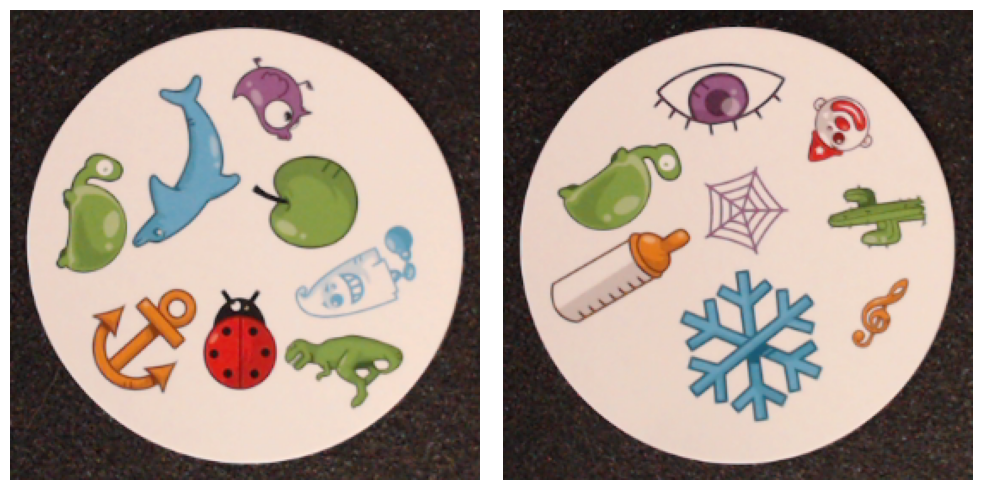

Model Wins!
Model Matching


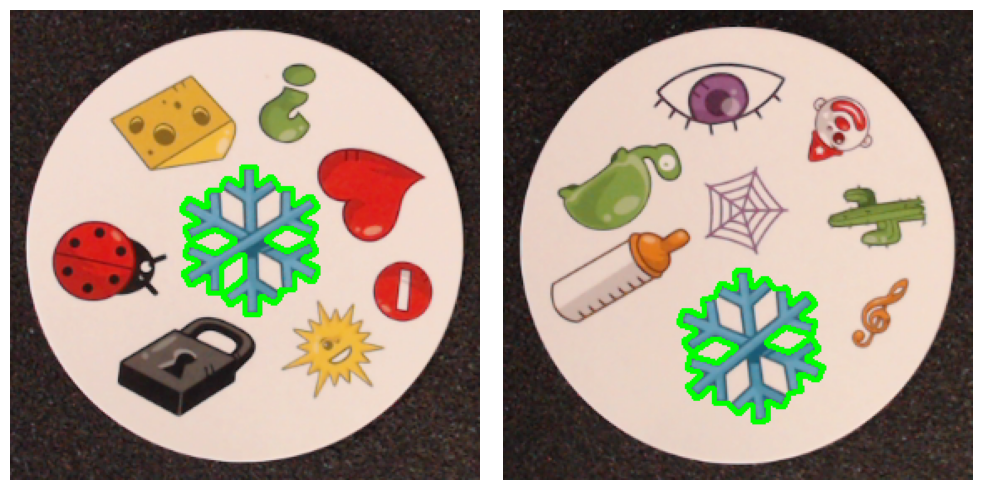

Supposed User Matching


KeyboardInterrupt: 

In [5]:
# Initialize game variables
cards = os.listdir("dobble_deck08_cards_55")
random.shuffle(cards)

user_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
cards.pop(0)
model_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
cards.pop(0)
shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
cards.pop(0)

# Game loop
while len(cards) > 0:
    # Get shared icons and contours
    shared_icons, shared_contours = get_icons(shared_card, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
    
    if model_move(model_card, shared_icons, shared_contours) is None or model_move(user_card, shared_icons, shared_contours) is None:
        print("Issue finding contours")
        print("Get new shared card")
        shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
        cards.pop(0)
        continue

    # Use ground truth for user and model matches
    model_match, model_contour, model_shared_contour = model_move(model_card, shared_icons, shared_contours)
    user_match, user_contour, user_shared_contour = model_move(user_card, shared_icons, shared_contours)
    
    # Display user card and shared card initially
    display_card(user_card, shared_card, None, None)
    
    player_choice = get_user_move(user_match)
    if player_choice:
        # If the user wins this round
        print("Correct!")
        user_card = shared_card
        time.sleep(1)
        # break
    else:
        print("Model Wins!")
        print("Model Matching")
        display_card(model_card, shared_card, model_contour, model_shared_contour)
        print("Supposed User Matching")
        display_card(user_card, shared_card, user_contour, user_shared_contour)
        model_card = shared_card
        time.sleep(1)
        # break

    # Update shared card
    shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
    cards.pop(0)
print("No more cards left in the deck!")


In [ ]:
# cards = os.listdir("dobble_deck08_cards_55")
# # random.shuffle(cards)

# user_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
# cards.pop(0)
# model_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
# cards.pop(0)
# shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
# cards.pop(0)

# while len(cards) > 0:
#     shared_icons, shared_contours = get_icons(shared_card, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
#     if model_move(model_card, shared_icons, shared_contours) is None or model_move(user_card, shared_icons, shared_contours) is None:
#         print("Issue finding contours")
#         print("Get new shared card")
#         shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
#         cards.pop(0)
#         continue
#     model_match, model_contour, model_shared_contour = model_move(model_card, shared_icons, shared_contours)
#     # use this to establish ground truth for now
#     user_match, user_contour, user_shared_contour = model_move(user_card, shared_icons, shared_contours)
#     display_card(user_card, shared_card, user_contour, user_shared_contour)
#     # display_card(model_card, shared_card, model_contour, model_shared_contour)
    
#     player_choice = get_user_move(user_match)
#     ## Update deck
#     if player_choice:
#         # if user wins
#         user_card = shared_card
#         print("Correct!")
#     else:
#         model_card = shared_card
#         print("Model Wins!")
#     shared_card = cv2.imread(join("dobble_deck08_cards_55", cards[0]))
#     cards.pop(0)
